<a href="https://colab.research.google.com/github/skbetz54/MLB_Statcast_Project/blob/main/Statcast_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **2019 Baltimore Orioles Hit Classification**
#### *By Sam Kolodrubetz*
[github repository link](https://github.com/skbetz54/MLB_Statcast_Project)

*Data sourced from the [baseball savant search function](baseballsavant.mlb.com/statcast_search)*. Download instructions can be found on the github link.
### **Introduction**

Technological advancements have helped us collect data in new ways that were once inconceivable. One such example, and the focus of this project, is the implementation of *Statcast* by Major League Baseball (MLB), which uses 12 sensors around a stadium to track everything from running speed, hit distance and more. The goal of this project is to determine if, given various Statcast metrics, I can build a machine learning model that can correctly classify a hit or an out. There have been several attempts to do this before, with [one using a random forest](https://tht.fangraphs.com/using-statcast-data-to-predict-hits/) achieving an accuracy, precision, and recall of 91.1%, 90.50%, and 83.70%, respectively. 

There were a couple main problems that I faced and wanted to test throughout my model creation process:
1. *Imbalanced Data* - given the nature of batting in baseball, there is an inherent imbalance between classes (getting 3 out of 10 hits is considered very good). First, this changes the metrics that are applicable to our model evaluations; precision and recall for the positive/minority class (hits) will hold much more weight than overall accuracy. Additionally, will this imbalance impact our model's efficacy? To test this, I ran similar tests on 
2. *Generalization* - There is variation between hitting statistics for different baseball teams in the MLB (hitter caliber, stadium dimensions). Will a model trained on one team perform well on another? To test this, I compiled the best-performing models in Part 1 and tested it on a different baseball team. 

*Note:* For information on the data cleaning process, check out the "Statcast - Data Cleaning" Colab notebook in the repository. Additionally, you can find some exploratory data analysis in the "Statcast - EDA" notebook in the repository.

## **Part 1 - Model Creation and Evaluation**

Part 1 is divided into  subsections, divided by varying the number of features present in the dataset (2, and all non-derived features, respectively). Additionally, to see how the imbalanced classes impact the models, each subsection will compare results from the base models and models using various techniques used to deal with class imbalance.

We will start by loading our cleaned dataset from the repo (found in the link at the top of the page). Additionally, I create a simple function "stats_table" that will allow for a model to be trained and tested, with outputs of important metrics displayed in a simple format.

In [2]:
import pandas as pd
""" One of the most tidious parts of this project was cleaning the data, which is why it is 
housed in a separate Colab notebook. First, I needed to create the target variable as it wasn't
present before. Second, there were several variables with dtype 'object' that held valuable 
information, so I either had to transform it into a numerical variable, or use OneHotEncoding
to capture the information.
"""
url = "https://raw.githubusercontent.com/skbetz54/MLB_Statcast_Project/main/Data/baltimore_2019_cleaned.csv"

df = pd.read_csv(url, header=0, index_col=0)
 
df.shape

(5655, 56)

In [3]:
def stats_table(model, X_train, y_train, X_test, y_test):

  """ stats_table: a function to train a classifier and print various metrics into a table
      --------------
      Parameters:
        model: the classifying model the function is using
        X_train: training set of feature variables
        y_train: training set of target variables
        X_test: test set of feature variables 
        y_test: test set of target variables
      --------------
      Output:
        The output will be a prettytable with model metrics of overall accuracy, precision, recall, 
        and F1 Score. Additionally, a confusion matrix will print as well. 
  """
  from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
  import prettytable
  import numpy as np

  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)

  a_score = accuracy_score(y_test, y_pred)
  p_score = precision_score(y_test, y_pred)
  r_score = recall_score(y_test, y_pred)
  f_score = f1_score(y_test, y_pred)

  pretty = prettytable.PrettyTable()
  pretty.add_column('Test',['Accuracy','Precision','Recall','F1 Score'], valign = 'm')
  pretty.add_column('Score', ['%.5f' % a_score, '%.5f' % p_score, '%.5f' % r_score, '%.5f' % f_score])
  
  a = np.concatenate(confusion_matrix(y_test,y_pred)).tolist()
  pretty_cm = prettytable.PrettyTable()
  pretty_cm.add_column('  ', ['Actual: Out', 'Actual: Hit'])
  pretty_cm.add_column('Predicted: Out', [a[0], a[2]])
  pretty_cm.add_column('Predicted: Hit', [a[1], a[3]])
  
  print(type(model).__name__)
  print(pretty, end=' ')
  print('\n')
  print(pretty_cm)

## **Part 1.1 - 2-feature subset**
One of the most widely-known Statcast metrics are launch angle and launch speed, which measure the (you guessed it) speed and angle of the baseball when it is hit. It is also [regarded highly when players are training](https://www.washingtonpost.com/sports/2019/05/14/mlb-teams-emphasize-exit-velocity-launch-angle-many-high-school-players-have-followed/). In this section I will only be using these two features from the dataset to determine how good these two metrics are at determining a hit.

The models being created in this section are:
1. A majority vote classifier made of logistic regression, K-nearest neighbors, and a decision tree classifier
2. A random forest classifier
3. Gradient-boosted decision trees

Additionally, for balancing the models in this section I will be using (where applicable) the 'balanced' *class_weight* parameter, which assigns weights to the class that are ["inversely proportional to class frequencies in the input data"](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html). In other words, the balanced model will penalize the misclassification of the minority class (hits) more than that of the majority class (outs). Let's first look at a visualization of these two features plotted against each other.

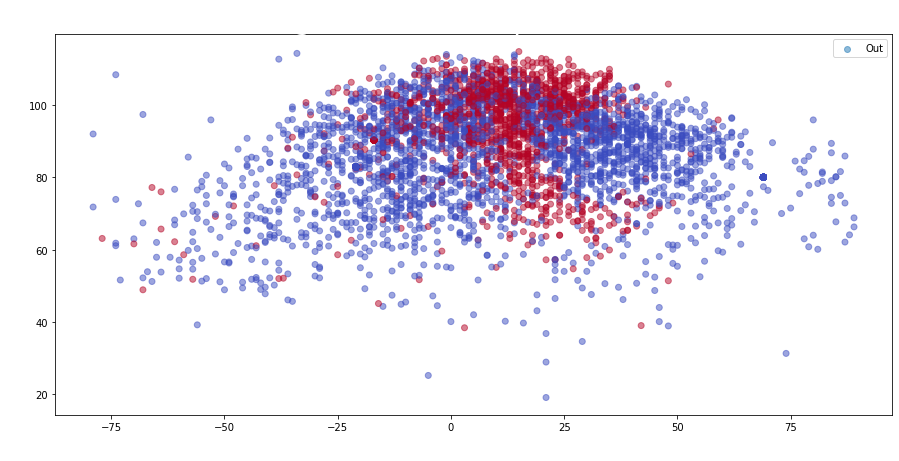

In [4]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15,7))
plt.scatter(x = df['launch_angle'], y = df['launch_speed'], alpha = 0.5, c = df['HitClf'], cmap = 'coolwarm')
plt.title("Launch Angle vs Launch Speed - Hits and Outs", fontsize = 28, color = 'white')
plt.xlabel("Launch-angle (degrees)", fontsize = 18, color = 'white')
plt.ylabel("Launch Speed (MPH)", fontsize = 18, color = 'white')
plt.legend(['Out','Hit'])

plt.show()

*Discussion:*

As we see in the plot above, there is clearly a "sweet spot" for the correct launch speed and angle. Therefore, it makes sense that baseball players would train to get their swings in this zone. However, does this translate to modeling hits vs. outs?

In [5]:
# Creating our X and y numpy arrays, flattening the y to allow for input into our models 

# Events like strikeouts are stored as NaN for various features like these, so 
# filling all NaNs with 0 would be the same as saying they did not hit the ball, 
# which still makes sense from a model's perspective.
X = df[['launch_angle','launch_speed']].fillna(0).to_numpy()
y = df[['HitClf']].to_numpy()

import numpy as np
y = np.ndarray.flatten(y)

# creating train and test sets for our models
from sklearn.model_selection import train_test_split

#Since the dataset is relatively large, I chose to have a smaller test size of .2
# (compared to .25 or .3) because I wanted to have as much data as possible to train on.
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=1, stratify=y)

#### **Majority Vote Classifier**

I am first going to test a majority vote classifier using 3 different models: logistic regression, K-nearest neighbors, and a single decision tree. The first output is without attempting to balance the data, and the second is with implementing a "balanced" *class_weight* parameter. A discussion of the results will follow the two models.

In [6]:
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
# The next two imports will be used to create a pipeline for the KNN algorithm, enabling us to scale just this classifier
from sklearn.pipeline import Pipeline 
from sklearn.preprocessing import StandardScaler


lr = LogisticRegression(solver ='lbfgs', max_iter = 10000, random_state=1, C=.001)
knn = KNeighborsClassifier(n_neighbors=15, p=2, metric='minkowski')
pipe = Pipeline([['sc', StandardScaler()],
                  ['clf', knn]])
# After testing, a max_depth of 7 was found to be the best-performing decision tree model.
# This will in turn be used for our gradient boosted classifier and random forest
dt = DecisionTreeClassifier(max_depth = 7, random_state = 1, criterion='gini', max_features=2)

mvclf = VotingClassifier(estimators =[('lr', lr), ('knn', pipe), ('dt',dt)],
                         voting = 'hard') 
""" hard voting means the output will be determined by the predicted class label rather than class probability.
I chose this rather than soft because with this binary classification task where there is much overlap
(especially with these two features), so the probabalistic outputs could give weak answers (probability
close to 50%). I decided that it would be better 

"""
stats_table(mvclf, X_train, y_train, X_test, y_test)

VotingClassifier
+-----------+---------+
|    Test   |  Score  |
+-----------+---------+
|  Accuracy | 0.86384 |
| Precision | 0.77232 |
|   Recall  | 0.62681 |
|  F1 Score | 0.69200 |
+-----------+---------+ 

+-------------+----------------+----------------+
|             | Predicted: Out | Predicted: Hit |
+-------------+----------------+----------------+
| Actual: Out |      804       |       51       |
| Actual: Hit |      103       |      173       |
+-------------+----------------+----------------+


In [7]:
# MVC using balancing technique to weight the minority class higher
# This is the same block of code as above, except we are now using class_weight = 'balanced' to account for the imbalanced classes
lr = LogisticRegression(solver ='lbfgs', max_iter = 10000, random_state=1, C=.001, class_weight='balanced')
knn = KNeighborsClassifier(n_neighbors=11, p=2, metric='minkowski')
pipe = Pipeline([['sc', StandardScaler()],
                  ['clf', knn]])
dt = DecisionTreeClassifier(max_depth = 7, random_state = 1, criterion='gini', max_features=2, class_weight='balanced')

mvclf = VotingClassifier(estimators =[('lr', lr), ('knn', pipe), ('dt',dt)],
                         voting = 'hard') #hard voting means the output will be determined by the predicted class label rather than class probability

stats_table(mvclf, X_train, y_train, X_test, y_test)

VotingClassifier
+-----------+---------+
|    Test   |  Score  |
+-----------+---------+
|  Accuracy | 0.80106 |
| Precision | 0.55889 |
|   Recall  | 0.87681 |
|  F1 Score | 0.68265 |
+-----------+---------+ 

+-------------+----------------+----------------+
|             | Predicted: Out | Predicted: Hit |
+-------------+----------------+----------------+
| Actual: Out |      664       |      191       |
| Actual: Hit |       34       |      242       |
+-------------+----------------+----------------+


*Discussion:*

As we see above, balancing the individual models by increasing the weight of the minority class had an adverse impact on the majority vote classifier, substituting overall accuracy and precision of the model for a better recall. While more actual hits were classified as such, the increased penalty of misclassifying hits made the model predict many more than actually present

#### **Random Forest on 2-Feature Subset**
Here I am creating a Random Forest classifier on "launch_angle" and "launch_speed"

In [8]:
from sklearn.ensemble import RandomForestClassifier
# For speed purposes, 300 estimators were used. Considerable differences in the performance occurred in random forests with n_estimators > 1500.
forest = RandomForestClassifier(n_estimators=300, criterion='gini', random_state = 1, max_depth=7)

stats_table(forest, X_train, y_train, X_test, y_test)

RandomForestClassifier
+-----------+---------+
|    Test   |  Score  |
+-----------+---------+
|  Accuracy | 0.86561 |
| Precision | 0.75410 |
|   Recall  | 0.66667 |
|  F1 Score | 0.70769 |
+-----------+---------+ 

+-------------+----------------+----------------+
|             | Predicted: Out | Predicted: Hit |
+-------------+----------------+----------------+
| Actual: Out |      795       |       60       |
| Actual: Hit |       92       |      184       |
+-------------+----------------+----------------+


In [9]:
%%time
from sklearn.ensemble import RandomForestClassifier

forest = RandomForestClassifier(n_estimators=300, criterion='gini', random_state = 1, max_depth=7, class_weight='balanced')

stats_table(forest, X_train, y_train, X_test, y_test)

RandomForestClassifier
+-----------+---------+
|    Test   |  Score  |
+-----------+---------+
|  Accuracy | 0.81698 |
| Precision | 0.58519 |
|   Recall  | 0.85870 |
|  F1 Score | 0.69604 |
+-----------+---------+ 

+-------------+----------------+----------------+
|             | Predicted: Out | Predicted: Hit |
+-------------+----------------+----------------+
| Actual: Out |      687       |      168       |
| Actual: Hit |       39       |      237       |
+-------------+----------------+----------------+
CPU times: user 867 ms, sys: 4.6 ms, total: 872 ms
Wall time: 872 ms


*Discussion:*

Again we have a similar result to the majority vote classifier, where overall accuracy and precision have been sacrificed to better capture *all hits* in the test dataset. Thus, all models are not very accurate when we only have two features for our classification, and the majority vote classifier is the best in terms of recall. MVC will be our model to use on the 2-feature Chicago Cubs subset in Part 2.

## **Part 1.2 - Expanded Dataset with ADASYN and SVMSMOTE**

In this section I introduce the rest of the feature space (43). The first problem that arose is the fact that some Statcast variables are derived from others. For example, "woba_value" calculates a weighted batting average, which would be highly correlated to "HitClf" because a higher woba means a higher likelihood of a hit. Therefore, I had to audit these derived columns so they wouldn't be included in the models. 

After training and test sets are created, I implement both a gradient-boosted classifier and another random forest on the unchanged dataset. Then to test how fixing the class imbalance, I implement an upsampling technique called ADASYN from scikitlearn's imbalanced-learn (imblearn). More detail on this technique can be found below.


*Note:* 

Because we are working with much higher dimensions, we will forego the MVC from now on, as the feature space is to large for these tests to perform with any accuracy.

In [10]:
# Compile all non-derived features from the dataset into a new dataframe
# I was unable to find a way to get this subset that didn't involve hardcoding 
df1 = df[['hit_location','hit_distance_sc','launch_angle','launch_speed',
        'hc_x','hc_y','strikes','release_spin_rate','plate_x','plate_z',
        'release_pos_y','game_pk','az','ay','ax','vz0','vy0','zone','release_pos_z',
        'pitch_number','at_bat_number','release_pos_x','effective_speed',
        'sz_top','vx0','sz_bot','release_extension','pfx_x','inning','balls','outs_when_up',
        'x0_SL','opp_hand','x0_SI','x0_FF','x0_FT','x0_CH','x0_FC','x0_KC','x0_FS',
        'x0_CU','x0_FO']]

# Again, create our feature arrays and split them into training and test sets.
X = df1.fillna(0).to_numpy()

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=1, stratify=y)

#### **Random Forest and Gradient-Boosted Classifier**



In [11]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
"""The GradientBoostingClassifier below typically uses a loss function 'deviance',
which is the same as using the loss function of logistic regression. Exponential loss
on the other hand implements the AdaBoost algorithm, which is beneficial to an addative
model like gradient boosting. Upon experimentation, loss='exponential' outperformed
loss='deviation' in almost all cases. 
"""
gb_clf = GradientBoostingClassifier(random_state = 1, max_depth=7, n_estimators = 300, learning_rate = .01, loss = 'exponential')
forest = RandomForestClassifier(n_estimators=350, criterion='gini', random_state = 1, max_depth=6, max_features=None)

stats_table(gb_clf, X_train, y_train, X_test, y_test)
stats_table(forest, X_train, y_train, X_test, y_test)

GradientBoostingClassifier
+-----------+---------+
|    Test   |  Score  |
+-----------+---------+
|  Accuracy | 0.93811 |
| Precision | 0.94783 |
|   Recall  | 0.78986 |
|  F1 Score | 0.86166 |
+-----------+---------+ 

+-------------+----------------+----------------+
|             | Predicted: Out | Predicted: Hit |
+-------------+----------------+----------------+
| Actual: Out |      843       |       12       |
| Actual: Hit |       58       |      218       |
+-------------+----------------+----------------+
RandomForestClassifier
+-----------+---------+
|    Test   |  Score  |
+-----------+---------+
|  Accuracy | 0.92838 |
| Precision | 0.96651 |
|   Recall  | 0.73188 |
|  F1 Score | 0.83299 |
+-----------+---------+ 

+-------------+----------------+----------------+
|             | Predicted: Out | Predicted: Hit |
+-------------+----------------+----------------+
| Actual: Out |      848       |       7        |
| Actual: Hit |       74       |      202       |
+-----------

#### **ADASYN and SVMSMOTE**

Adaptive Synthetic (ADASYN)[(documentation)](https://imbalanced-learn.readthedocs.io/en/stable/generated/imblearn.over_sampling.ADASYN.html) sampling is a technique to generate "synthetic" sample data for the minority class (in our case, hits) using a K-nearest neighbor algorithm with a Euclidean distance metric. This generator, unlike random or SMOTE, creates this synthetic data with heavier emphasis on spaces where the density of the minority class is low. This generally occurs along the "borders" where the classes meet (sample spaces where 'out' and 'hit' data points may be located/overlapped). Below is an implementation of both models from the previous step (random forest and gradient-boosted decision tree). 

SVMSMOTE is an over-sampling technique to see if the process of over-sampling helps at all, this time using an imblearn process similar to ADASYN called SVMSMOTE [(documentation)](https://imbalanced-learn.readthedocs.io/en/stable/generated/imblearn.over_sampling.SVMSMOTE.html). SMOTE (Synthetic Minority Over Sampling) is similar to ADASYN, except for the fact that it does not bias the synthetic data towards non-homogeneous boundaries. SVMSMOTE works similarly to ADASYN near the boundaries, with this technique implementing an SVM classifier on the original data and adding synthetic points along the minority class' support vectors randomly according to k-nearest neighbors.

In [12]:
# Commented out because it is already installed, but need to install imblearn before running the next section.

# pip install -U imbalanced-learn

In [13]:
from imblearn.over_sampling import ADASYN
""" Since ADASYN uses the KNN algorithm, we need to determine the best choice for neighbors.
As mentioned in section 1.1 this was a time consuming task, but in this section I decided to 
opt for a smaller number of neighbors (compared to 15 above) due to ADASYN populating 
areas according to the inverse proportion of density of the minority class. This would mean
that there would likely not be as many neighbors as standard data points.
"""

ada = ADASYN(random_state=1, n_neighbors=8)

X_res, y_res = ada.fit_resample(X_train, y_train)

print(X_res.shape)
print(y_res.shape)

""" Creating a similar train/test split as before, this time with our resampled data.
Because we only want to train our data on the balanced set and test with our regular
data, we will only be using the training sets generated below. These will be paired
with our standard X_test and y_test generated above.
"""
X_train_res, X_test_res, y_train_res, y_test_res = train_test_split(
    X_res, y_res, test_size=0.2, random_state=1, stratify=y_res)

(6657, 42)
(6657,)


/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [14]:
stats_table(gb_clf, X_train_res, y_train_res, X_test, y_test)
stats_table(forest, X_train_res, y_train_res, X_test, y_test)

GradientBoostingClassifier
+-----------+---------+
|    Test   |  Score  |
+-----------+---------+
|  Accuracy | 0.93280 |
| Precision | 0.89370 |
|   Recall  | 0.82246 |
|  F1 Score | 0.85660 |
+-----------+---------+ 

+-------------+----------------+----------------+
|             | Predicted: Out | Predicted: Hit |
+-------------+----------------+----------------+
| Actual: Out |      828       |       27       |
| Actual: Hit |       49       |      227       |
+-------------+----------------+----------------+
RandomForestClassifier
+-----------+---------+
|    Test   |  Score  |
+-----------+---------+
|  Accuracy | 0.92927 |
| Precision | 0.86842 |
|   Recall  | 0.83696 |
|  F1 Score | 0.85240 |
+-----------+---------+ 

+-------------+----------------+----------------+
|             | Predicted: Out | Predicted: Hit |
+-------------+----------------+----------------+
| Actual: Out |      820       |       35       |
| Actual: Hit |       45       |      231       |
+-----------

In [15]:
%%time
from imblearn.over_sampling import SVMSMOTE

smote = SVMSMOTE(sampling_strategy='minority', random_state=1, k_neighbors=5)

X_res, y_res = smote.fit_resample(X_train, y_train)

print(X_res.shape)
print(y_res.shape)

stats_table(gb_clf, X_res, y_res, X_test, y_test)
stats_table(forest, X_res, y_res, X_test, y_test)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarni

(6842, 42)
(6842,)
GradientBoostingClassifier
+-----------+---------+
|    Test   |  Score  |
+-----------+---------+
|  Accuracy | 0.94164 |
| Precision | 0.91339 |
|   Recall  | 0.84058 |
|  F1 Score | 0.87547 |
+-----------+---------+ 

+-------------+----------------+----------------+
|             | Predicted: Out | Predicted: Hit |
+-------------+----------------+----------------+
| Actual: Out |      833       |       22       |
| Actual: Hit |       44       |      232       |
+-------------+----------------+----------------+
RandomForestClassifier
+-----------+---------+
|    Test   |  Score  |
+-----------+---------+
|  Accuracy | 0.92750 |
| Precision | 0.85401 |
|   Recall  | 0.84783 |
|  F1 Score | 0.85091 |
+-----------+---------+ 

+-------------+----------------+----------------+
|             | Predicted: Out | Predicted: Hit |
+-------------+----------------+----------------+
| Actual: Out |      815       |       40       |
| Actual: Hit |       42       |      234  

## **Part 1.3 - Feature Selection**

One of the biggest challenges of this project for me was at first trying to find non-ensemble methods to reduce the dimensionality, namely Principal Component Analysis (PCA). In the early stages of this project I tried to apply PCA to logistic regression and decision trees, but the scores were often lower than even their 2-feature counterparts. Therefore, PCA and other dimension reduction techniques were abandoned.

Instead, I chose to implement a random forest to choose the most important features of the dataset. Using Sebastian Raschka's code, I measure the importance of each feature to create a smaller subset.

 1) launch_angle                   0.148799
 2) hit_distance_sc                0.139739
 3) hit_location                   0.130849
 4) hc_y                           0.112828
 5) launch_speed                   0.094509
 6) hc_x                           0.057622
 7) az                             0.016268
 8) plate_x                        0.015782
 9) plate_z                        0.015778
10) vx0                            0.014689
11) ay                             0.014645
12) release_spin_rate              0.014584
13) vz0                            0.014583
14) release_pos_z                  0.014501
15) release_pos_x                  0.014432
16) release_pos_y                  0.014269
17) game_pk                        0.014186
18) vy0                            0.014075
19) ax                             0.013721
20) sz_top                         0.013630
21) effective_speed                0.013015
22) at_bat_number                  0.012808
23) sz_bot                      

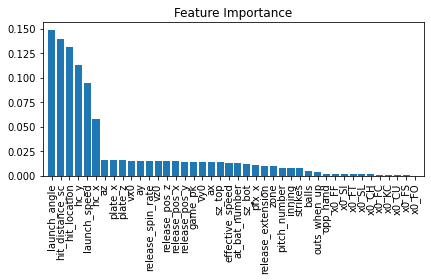

In [16]:
# This code was implemented from chapter 4 of Sebastian Raschka's "Python Machine Learning, 3rd Edition"
# can be found at: https://github.com/rasbt/python-machine-learning-book-3rd-edition/blob/master/ch04/ch04.ipynb

from sklearn.ensemble import RandomForestClassifier

feat_labels = df1.columns[:]

forest = RandomForestClassifier(n_estimators=500,
                                random_state=1)

forest.fit(X_train, y_train)
importances = forest.feature_importances_

indices = np.argsort(importances)[::-1]

for f in range(X_train.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30, 
                            feat_labels[indices[f]], 
                            importances[indices[f]]))

plt.title('Feature Importance')
plt.bar(range(X_train.shape[1]), 
        importances[indices],
        align='center')

plt.xticks(range(X_train.shape[1]), 
           feat_labels[indices], rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.tight_layout()
plt.show()

*Discussion:*

As we see above, there are 6 features that have a much higher feature importance than the rest: launch_angle, hit_distance_sc, launch_speed, hit_location, hc_y, and hc_x. 

In [17]:
%%time
df2 = df[['launch_angle','hit_distance_sc','launch_speed','hit_location','hc_y', 'hc_x']]

# Again, create our feature arrays and split them into training and test sets.
X = df2.fillna(0).to_numpy()

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=1, stratify=y)

forest = RandomForestClassifier(n_estimators=350, criterion='gini', random_state = 1, max_depth=7, max_features=None)
stats_table(forest, X_train, y_train, X_test, y_test)

RandomForestClassifier
+-----------+---------+
|    Test   |  Score  |
+-----------+---------+
|  Accuracy | 0.93192 |
| Precision | 0.97156 |
|   Recall  | 0.74275 |
|  F1 Score | 0.84189 |
+-----------+---------+ 

+-------------+----------------+----------------+
|             | Predicted: Out | Predicted: Hit |
+-------------+----------------+----------------+
| Actual: Out |      849       |       6        |
| Actual: Hit |       71       |      205       |
+-------------+----------------+----------------+
CPU times: user 2.57 s, sys: 6 ms, total: 2.57 s
Wall time: 2.58 s


In [18]:
from imblearn.over_sampling import SVMSMOTE

smote = SVMSMOTE(sampling_strategy='minority', random_state=1, k_neighbors=5)

X_res, y_res = smote.fit_resample(X_train, y_train)

print(X_res.shape)
print(y_res.shape)

forest = RandomForestClassifier(n_estimators=350, criterion='gini', random_state = 1, max_depth=6, max_features=None)

stats_table(forest, X_res, y_res, X_test, y_test)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarni

(6842, 6)
(6842,)
RandomForestClassifier
+-----------+---------+
|    Test   |  Score  |
+-----------+---------+
|  Accuracy | 0.92042 |
| Precision | 0.81419 |
|   Recall  | 0.87319 |
|  F1 Score | 0.84266 |
+-----------+---------+ 

+-------------+----------------+----------------+
|             | Predicted: Out | Predicted: Hit |
+-------------+----------------+----------------+
| Actual: Out |      800       |       55       |
| Actual: Hit |       35       |      241       |
+-------------+----------------+----------------+


*Discussion:*

As we see, the 6 features we selected created a relatively accurate hit classifier but did not perform as well as the full dataset. This is likely due to the small but not insignificant feature importances for the following 20-30 features. With only 6 features, while we are capturing a good amount of the variance, we still miss a good portion of it. Statcast batting data is complex; the same values could result in different outcomes (imagine a diving catch that should have been a hit), so leaving out anything that could differentiate a hit from an out could be detrimental

*Part 1 Conclusions*
Before I try to generalize my best models with another team's dataset, here are a few conlcusions on what I learned from the above analysis:
1. *Best performing model* - The model that performed the best in terms of what we would like to see for this data (high overall accuracy, good balance between recall and precision, high F1 score) was using the SVMSMOTE over-sampler to train a gradient-boosted classifier on the entire feature space, followed by using a random forest on the same feature space. 
2. *Precision-recall tradeoff* - I found that introducing balancing techniques would decrease the precision of the model and increase its recall. In general, this tradeoff is due to what the model wants to do; you can increase the likelihood of correctly classifying all of the positive class (high recall), or you can limit the variance of a data point being predicted as a positive class (high precision). This shows the importance of model tuning for a specific purpose, because different methods and hyperparameters may impact precision and recall in ways you do not want.
3. *Balanced models in higher dimensions perform better* - Similar to the last point, since recall is the most important metric for this case, the models that utilized tools to upsample the minority class (hits) had a better performance when both all 43 features were used and when we limited it to the most important 6 features. On the other hand, with only two features both the majority vote classifier and random forest that had 'balanced' class weights performed worse than their normal counterparts, misclassifying outs as hits at a much higher rate.

# **Part 2: Testing on Another Team - 2019 Chicago Cubs**
This testing will focus on 3 tests from above that performed best:
- Majority vote classifier for 2-feature subset (launch_angle and launch_speed)
- Gradient boosing classifier using SVMSMOTE on the entire dataset
- Random forest classifier using SVMSMOTE on the five-feature subset obtained from feature selection.

In [19]:
# Importing and creating our new "dfc" dataframe holding data from the Chicago Cubs' 2019 season.
url = "https://raw.githubusercontent.com/skbetz54/MLB_Statcast_Project/main/Data/chicago_2019_cleaned.csv"

dfc = pd.read_csv(url, header=0, index_col=0)
dfc.shape

(5494, 56)

In [20]:
# Re-initializing our datasets for both Orioles (to train) and Cubs (to test) seasons
# Orioles
X = df[['launch_angle','launch_speed']].fillna(0).to_numpy()
y = df[['HitClf']].to_numpy()
y = np.ndarray.flatten(y)

# creating train and test sets for our models
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=1, stratify=y)

# Cubs
X1 = dfc[['launch_angle','launch_speed']].fillna(0).to_numpy()
y1 = dfc[['HitClf']].to_numpy()
y1 = np.ndarray.flatten(y1)

In [21]:
lr = LogisticRegression(solver ='lbfgs', max_iter = 10000, random_state=1, C=.001)
knn = KNeighborsClassifier(n_neighbors=11, p=2, metric='minkowski')
pipe = Pipeline([['sc', StandardScaler()],
                  ['clf', knn]])
dt = DecisionTreeClassifier(max_depth = 7, random_state = 1, criterion='gini', max_features=2)

mvclf = VotingClassifier(estimators =[('lr', lr), ('knn', pipe), ('dt',dt)],
                         voting = 'hard') #hard voting means the output will be determined by the predicted class label rather than class probability
# printing out the MVC made in Part 1.1 and for the new data 
stats_table(mvclf, X_train, y_train, X_test, y_test)
stats_table(mvclf, X_train, y_train, X1, y1)

VotingClassifier
+-----------+---------+
|    Test   |  Score  |
+-----------+---------+
|  Accuracy | 0.87268 |
| Precision | 0.78947 |
|   Recall  | 0.65217 |
|  F1 Score | 0.71429 |
+-----------+---------+ 

+-------------+----------------+----------------+
|             | Predicted: Out | Predicted: Hit |
+-------------+----------------+----------------+
| Actual: Out |      807       |       48       |
| Actual: Hit |       96       |      180       |
+-------------+----------------+----------------+
VotingClassifier
+-----------+---------+
|    Test   |  Score  |
+-----------+---------+
|  Accuracy | 0.85420 |
| Precision | 0.74461 |
|   Recall  | 0.63085 |
|  F1 Score | 0.68302 |
+-----------+---------+ 

+-------------+----------------+----------------+
|             | Predicted: Out | Predicted: Hit |
+-------------+----------------+----------------+
| Actual: Out |      3830      |      296       |
| Actual: Hit |      505       |      863       |
+-------------+-------------

#### **Gradient-Boosted DT with SVMSMOTE**
As this was our best performing model in terms of a combination of all metrics, we will test the Cubs' dataset on our GradientBooostClassifier using SVMSMOTE to over-sample the Orioles' training set used to train the model.

In [22]:
df_cub = dfc[['hit_location','hit_distance_sc','launch_angle','launch_speed',
        'hc_x','hc_y','strikes','release_spin_rate','plate_x','plate_z',
        'release_pos_y','game_pk','az','ay','ax','vz0','vy0','zone','release_pos_z',
        'pitch_number','at_bat_number','release_pos_x','effective_speed',
        'sz_top','vx0','sz_bot','release_extension','pfx_x','inning','balls','outs_when_up',
        'x0_SL','opp_hand','x0_SI','x0_FF','x0_FT','x0_CH','x0_FC','x0_KC','x0_FS',
        'x0_CU']]
df_cub['x0_FO'] = np.zeros(df_cub.shape[0])

X1 = df_cub.fillna(0).to_numpy()

X = df1.fillna(0).to_numpy()

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=1, stratify=y)

smote = SVMSMOTE(sampling_strategy='minority', random_state=1, k_neighbors=5)

X_res, y_res = smote.fit_resample(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is d

In [23]:
%%time
stats_table(gb_clf, X_train_res, y_train_res, X1, y1)

GradientBoostingClassifier
+-----------+---------+
|    Test   |  Score  |
+-----------+---------+
|  Accuracy | 0.93211 |
| Precision | 0.86989 |
|   Recall  | 0.85526 |
|  F1 Score | 0.86251 |
+-----------+---------+ 

+-------------+----------------+----------------+
|             | Predicted: Out | Predicted: Hit |
+-------------+----------------+----------------+
| Actual: Out |      3951      |      175       |
| Actual: Hit |      198       |      1170      |
+-------------+----------------+----------------+
CPU times: user 26.5 s, sys: 4.98 ms, total: 26.5 s
Wall time: 26.5 s


In [24]:
X1.shape

(5494, 42)

In [25]:
df_cub = dfc[['launch_angle','hit_distance_sc','launch_speed','hit_location','hc_y', 'hc_x']]
X1 = df_cub.fillna(0).to_numpy()

# Again, create our feature arrays and split them into training and test sets.
X = df2.fillna(0).to_numpy()

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=1, stratify=y)

smote = SVMSMOTE(sampling_strategy='minority', random_state=1, k_neighbors=5)
X_res, y_res = smote.fit_resample(X_train, y_train)

# forest = RandomForestClassifier(n_estimators=300, criterion='gini', random_state = 1, max_depth=7)
stats_table(forest, X_res, y_res, X1, y1)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarni

RandomForestClassifier
+-----------+---------+
|    Test   |  Score  |
+-----------+---------+
|  Accuracy | 0.92519 |
| Precision | 0.82136 |
|   Recall  | 0.89401 |
|  F1 Score | 0.85614 |
+-----------+---------+ 

+-------------+----------------+----------------+
|             | Predicted: Out | Predicted: Hit |
+-------------+----------------+----------------+
| Actual: Out |      3860      |      266       |
| Actual: Hit |      145       |      1223      |
+-------------+----------------+----------------+


# **Conclusions**
1. Balancing techniques - In general, using balancing methods that impact class weights in models will decrease the precision and overall accuracy of the model in favor of a higher recall.
2. Generalization - When tested on a different baseball team with [very different field dimensions](http://www.andrewclem.com/Baseball/Overlay_comparison.php), the models trained on the 2019 Baltimore Orioles only suffered a small decrease in accuracy, precision, and recall. 


## **Problems Encountered During Project**

- tuning model hyperparameters to get the best tradeoff between recall and precision. The gradient boosted classifier was especially different in this case, as the learning rate greatly changed the outcomes when changing even by less than a factor of 10. 
- dimension reduction - as mentioned above, I initially tried to implement Principal Component Analysis to reduce the dimensionality of my 43-feature dataset. However, tests consistently performed worse when using PCA on my model before training. Instead, I chose to reduce the dimensionality through feature selection by training a random forest. Additionally, 
- Choosing the correct method to over-sample the minority class (hits) - various techniques were used to do this - random over-sampling, standard SMOTE (where synthetic points aren't biased towards border areas) before settling on ADASYN and SVMSMOTE. I decided that having synthetic data placed in regions where hits weren't as prevalent would help train the model(s) to better account for these borderline cases.